In [2]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot

hide_input()

# How da heck do inputs to different dimensions of an ensemble work?


In [66]:
model = nengo.Network()

with model:

    n_neurons = 1
    # Let the `given` ensemble have n_neurons neurons
    given = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=2,seed=0
    )

    # perform experiment 3 times
    nengo.Connection(nengo.Node(1), given[0])
    nengo.Connection(nengo.Node(1), given[1])
    #
    # # Create dummy ensemble to read dendrite weights
    # dummy = nengo.Ensemble(64,dimensions=3,)
    #
    # # The 3 dendrites will generate soma currents:
    # # cos(8t)
    # conn0 = nengo.Connection(given[0], dummy[0], function=lambda x : x)
    # # cos^2(8t)
    # conn1 = nengo.Connection(given[1], dummy[1], function=lambda x : x ** 2)
    # # 0.5
    # conn2 = nengo.Connection(given[2], dummy[2], function=lambda x : 0.5)


    D_spikes = nengo.Probe(given.neurons)
    D_PSC = nengo.Probe(given.neurons, synapse=0.01)
    D_dims = nengo.Probe(given, synapse=0.01)

In [72]:
with nengo.Simulator(model) as sim:
    sim.run(1)
    eval_points, activities = tuning_curves(given, sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

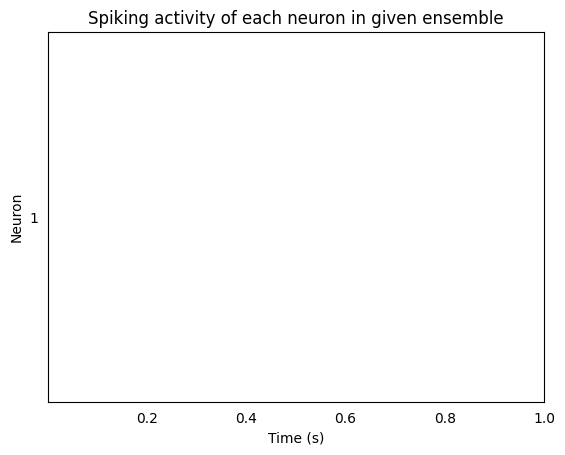

In [68]:
rasterplot(sim.trange(), sim.data[D_spikes])
plt.ylabel("Neuron")
plt.xlabel("Time (s)")
plt.title('Spiking activity of each neuron in given ensemble')
plt.show()


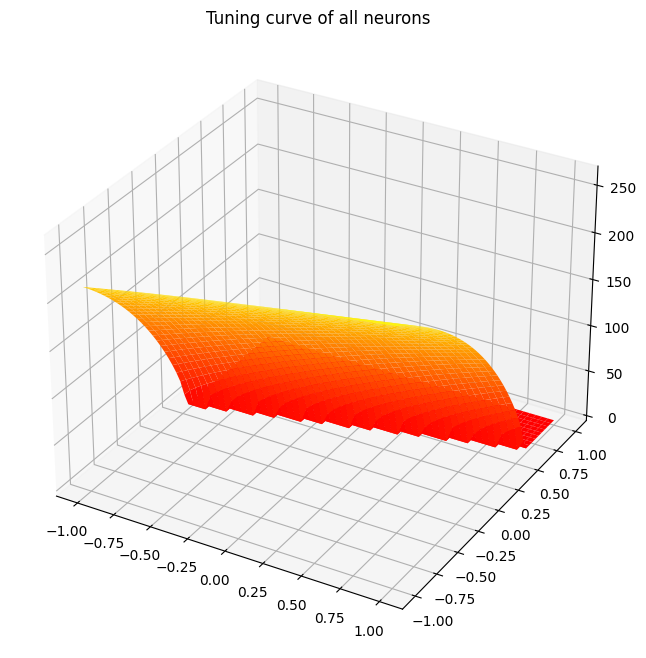

In [73]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(projection="3d")
ax.set_title("Tuning curve of all neurons")
for i in range(given.n_neurons):
    ax.plot_surface(
        eval_points.T[0], eval_points.T[1], activities.T[i], cmap=plt.cm.autumn
    )


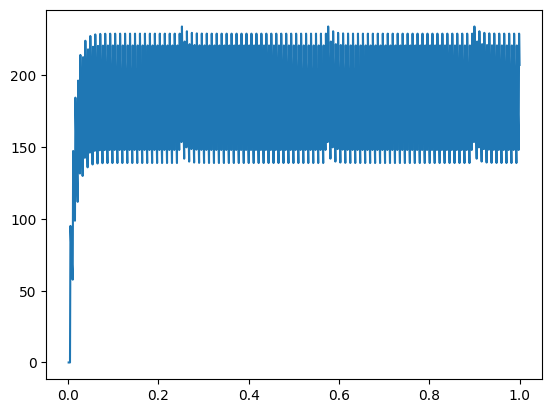

In [65]:
plt.plot(sim.trange(),sim.data[D_PSC])

# What do the dendrites look like?

Each dendrite is an array of length `n_neurons`. Each neuron in `given` corresponds to an array element, its assigned weight.
- Large (small) weight magnitude signifies:
   - high (low) synaptic strength
   - synapse close to (far from) soma
- Positive (negative) weight signifies excitatory (inhibitory) connection

We do principle neuron analysis by looking at highest weights. (I suggest including all neurons first and then cutting down.)

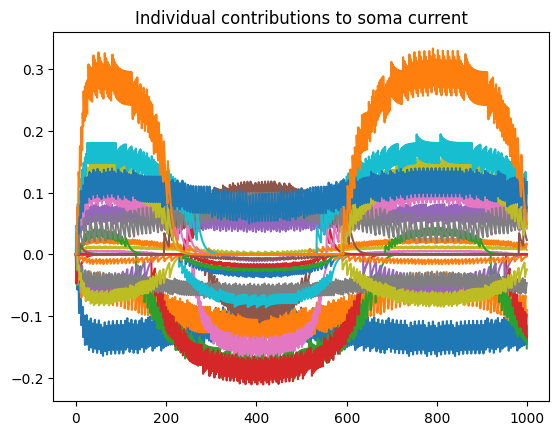

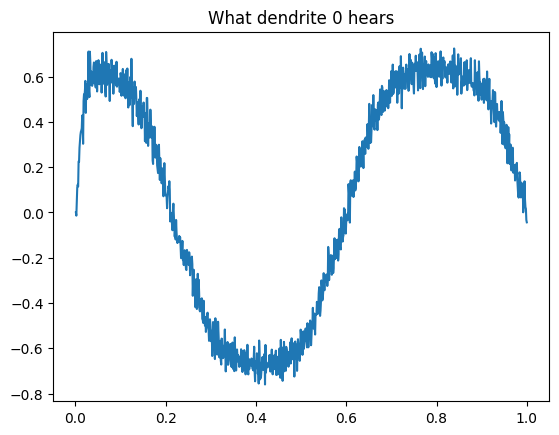

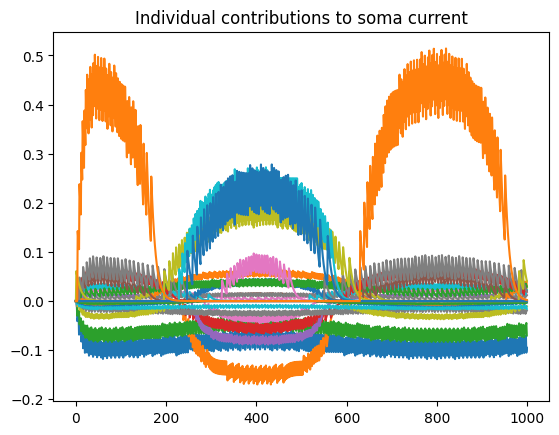

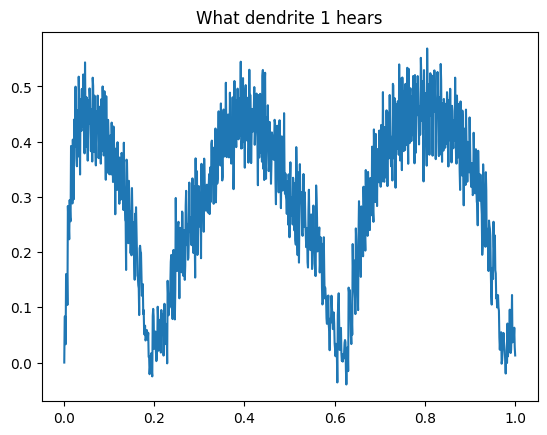

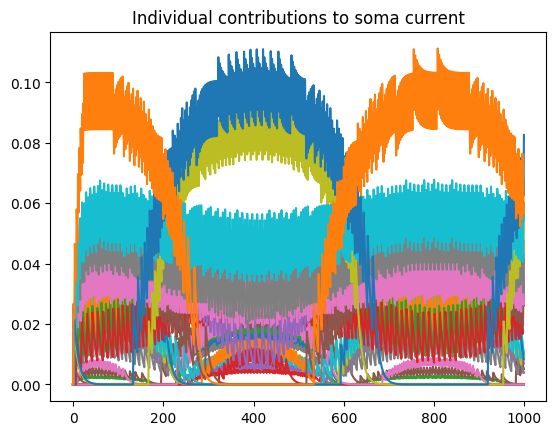

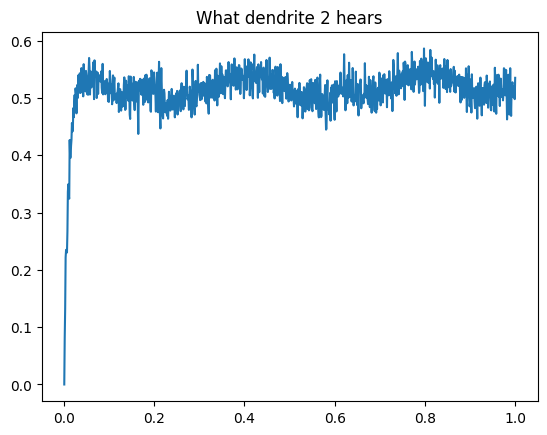

In [199]:
# number of principle neurons to include
n = 32

conns = [conn0,conn1,conn2]
# for each dimension
for d in range(3):
    # coax weights out of nengo
    dendrite = sim.data[conns[d]].weights[0]  # a connection can only have one set of weights but it's double-wrapped

    # identify primary neurons
    primary_components = np.argsort(dendrite)[:n]

    # resulting soma current
    sum = np.zeros(sim.trange().shape)

    # identify individual contribution = weight * post-synaptic current if onehot
    for neuron in primary_components:
        contrib = dendrite[neuron] * sim.data[D_PSC][:, neuron]
        plt.plot(contrib)
        sum += contrib
    plt.title('Individual contributions to soma current')
    plt.show()

    # the resulting soma current should be magical
    plt.plot(sim.trange(), sum)
    plt.title(f'What dendrite {d} hears')
    plt.show()

# Conclusion
Dendrites 0, 1, and 2 respectively heard $\cos(8t),\cos ^{2}(8t),0.5$.

Dendrite 0's job was particularly easy because we used a $\cos(8t)$ to poke the `given` ensemble. Dendrite 2 did reasonably well!